# Occupancy Detector - Multivariate Time Series Analysis

This notebook will analyze the [occupancy detection dataset](https://archive.ics.uci.edu/dataset/357/occupancy+detection), which provides multivariate timeseries information that can be used to predict whether or not the room is occupied at the time.

## Setup

Need to setup this notebook prior to running any experiments. All blocks in this section need to be ran before attempting to run any other code blocks in this notebook.

### Google Colab

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

### Imports

In [3]:
import datetime
import logging
import pathlib
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

### Environment
Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-13 15:34:30.112447


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers
Defining helper functions to make split certain functionality out of tasks.

In [9]:
def download_and_format_data(file: pathlib.Path) -> pd.DataFrame:
    """ Helper function to download the datset from a file, then properly format it
        into a nice dataframe.

        Args:
            file (pathlib.Path): the path to the txt file to download.

        Returns
            (pd.DataFrame) the structured dataframe.
    """
    data = data_toolbox.read_txt_file_from_directory(str(file))

    # Extracting column names
    columns = data[0].replace('"', '').split(',')
    columns.insert(0, 'id')

    cleaned_data = []
    for row in data[1:]:
        if len(row) == 0:
            continue

        split_data = row.replace('"', '').split(',')
        cleaned_data.append({
            columns[0]: int(split_data[0]),
            columns[1]: datetime.datetime.strptime(split_data[1], '%Y-%m-%d %H:%M:%S'),
            columns[2]: float(split_data[2]),
            columns[3]: float(split_data[3]),
            columns[4]: float(split_data[4]),
            columns[5]: float(split_data[5]),
            columns[6]: float(split_data[6]),
            columns[7]: int(split_data[7]),
        })

    return pd.DataFrame(cleaned_data)

In [10]:
def cyclically_encode_timestamp(hours_of_day: typing.Union[typing.List[int], np.ndarray[int]]) -> tf.Tensor:
    """ Creates a cyclically encoded timestamp based off the hour of day.

        Args:
            hours_of_day (typing.Union[typing.List[int], np.ndarray[int]]): the hours of the day to cyclically encode.

        Returns:
            (tf.Tensor) the cyclically encoded values for the given hours.
    """
    tensor_hours = tf.convert_to_tensor(hours_of_day)

    month_sin = tf.math.sin(2 * np.pi * hours_of_day / 24)
    month_cos = tf.math.cos(2 * np.pi * hours_of_day / 24)

    return tf.stack([month_sin, month_cos], axis=1)

In [11]:
def plot_multivariate_data(data_df: pd.DataFrame) -> None:
    """ Plots the various features against time steps across 5 graphs.

        Args:
            data_df (pd.DataFrame): the dataframe generated from output of `download_and_format_data` to plot
    """
    fig, axs = plt.subplots(6, figsize=(12, 8), sharex=True)

    fig.suptitle('Multivariate Data')
    x = data_df['id']

    features_df = data_df.drop('id', axis=1).drop('date', axis=1)

    for index, feature in enumerate(features_df):
        axs[index].plot(x, data_df[feature])
        axs[index].set_title(feature.capitalize())

    fig.tight_layout()

In [12]:
def make_windowed_dataset(series: np.ndarray,
                          window_size: int = 7,
                          batch_size: int = 32, 
                          include_occupancy: bool = True) -> tf.data.Dataset:
    """ Creates a windowed dataset from the given series.

        Args:
            series (ArrayLike): the series to create the windowed dataset from.
            window_size (int): the size of the window.
            batch_size (int): the size of the batch.
        
        Returns:
            (tf.data.Dataset) the windowed dataset.
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Only trying to predict a single binary value on outcome (occupied or not occupied)
    if include_occupancy:
        dataset = dataset.map(lambda window: (window[:-1, :], window[-1][-1]))
    else:
        dataset = dataset.map(lambda window: (window[:-1, :-1], window[-1][-1]))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [13]:
def make_predictions(model: tf.keras.models.Model, dataset: tf.data.Dataset) -> np.ndarray:
    """ Makes the predictions for the corresponding model and outputs the predicted classes.

        Args:
            model (tf.keras.models.Model): the model to make predictions with.
            dataset (tf.data.Dataset): the dataset to make predictions on.

        Returns:
            (np.ndarray) the predicted classes
    """
    pred_probs = model.predict(dataset)

    return tf.squeeze(tf.cast(tf.round(pred_probs), dtype=tf.int32))

In [14]:
def plot_occupancy_pred_vs_true(y_pred: tf.Tensor,
                                data_df: pd.DataFrame,
                                start: int,
                                end: int,
                                test_name: str):
    """ Plots the occupancy predictions vs the actual occpancy.

        Args:
            y_pred (tf.Tensor) the models predicted class (1, 0) of whether the room is occupied.
            data_df (pd.DataFrame) the dataframe that relates to the same data the preds were made on.
            start (int) where to start the graph at  (zooms in graph).
            end (int) where to end the graph at (zooms in graph).
            test_name (str) the title for the predicted data
    """
    # Data Visualization
    plt.figure(figsize=(12,4))
    ml_toolbox.analysis.timeseries.plot_price_vs_timesteps(data_df['id'],
                                                           data_df['Occupancy'],
                                                           format='-',
                                                           start=start,
                                                           end=end,
                                                           label='Test Data',
                                                           new_figure=False)

    ml_toolbox.analysis.timeseries.plot_price_vs_timesteps(data_df['id'].to_numpy()[1:],
                                                           y_pred,
                                                           format='-',
                                                           start=start,
                                                           end=end,
                                                           label=test_name,
                                                           new_figure=False)

In [15]:
def get_ensemble_models(input_shape: typing.Tuple,
                        train_data: tf.data.Dataset,
                        test_data: tf.data.Dataset,
                        num_iter: int = 10,
                        num_epochs: int = 100,
                        hidden_layer_sizes: typing.Optional[typing.List[int]] = None) -> typing.List[tf.keras.models.Sequential]:
    """ Returns a list of num_iter models each trained on loss function metrics.

        Example:
            num_iter=10 and loss_fn=['mae', 'mse', 'mape'],  a list of 30 trained models
            will be returned: 10 * len(['mae', 'mse', 'mape'])

        Args:
            input_shape (typing.Tuple): the input shape.
            train_data (tf.data.Dataset): the dataset to train the models on.
            test_data (tf.data.Dataset): the dataset to test/validate the models on.
            num_iter (int): the number of models for each loss function metric.
            num_epochs (int): the number of epochs to train the model on.
            hidden_layer_sizes (typing.Optional[typing.List[int]): the corresponding hidden layer
                sizes for dense layers.

        Returns:
            (List[Model]) the list of trained models.
    """
    hidden_layer_sizes = hidden_layer_sizes or [128, 128]

    ensemble_models = []

    for i in range(num_iter):
        print(f'Optimizing model by reducing: for {num_epochs}, model number: {i}')

        inputs = tf.keras.layers.Input(shape=input_shape)

        x = inputs
        for hidde_layer_size in hidden_layer_sizes:
            x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)

        x = tf.keras.layers.Flatten()(x)

        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs, outputs, name=f'ensemble_model_{i}')

        # Compile Model
        model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.legacy.Adam(),
                      metrics=['accuracy'])

        # Fit Model
        model.fit(train_data,
                  epochs=num_epochs,
                  verbose=0,
                  validation_data=test_data)

        ensemble_models.append(model)

    return ensemble_models

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file that was downloaded to the data directory, directly from the website.
* [occupancy detection dataset](https://archive.ics.uci.edu/dataset/357/occupancy+detection)

### Download & Format Data

In [16]:
DATA_DIR = pathlib.Path('./data/')

TEST_DATA_FILE = DATA_DIR / 'datatest2.txt'
TRAIN_DATA_FILE = DATA_DIR / 'datatraining.txt'

#### Viewing Data

Going to look at how the data comes in before I structure it to ensure I know how I 

In [17]:
raw_data = data_toolbox.read_txt_file_from_directory(str(TRAIN_DATA_FILE))

In [18]:
raw_data[:3]

['"date","Temperature","Humidity","Light","CO2","HumidityRatio","Occupancy"',
 '"1","2015-02-04 17:51:00",23.18,27.272,426,721.25,0.00479298817650529,1',
 '"2","2015-02-04 17:51:59",23.15,27.2675,429.5,714,0.00478344094931065,1']

#### Download Data

After viewing the data from the raw file, I used the helper function, `download_and_format_data`, to generate structured dataframes of the downloaded data.

In [19]:
train_data_df = download_and_format_data(TRAIN_DATA_FILE)
test_data_df = download_and_format_data(TEST_DATA_FILE)

train_data_df.head()

,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### Analyzing Data

In [20]:
train_data_df

,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
1,2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
2,3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
3,4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
4,5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...,...
8138,8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8139,8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8140,8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8141,8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [21]:
train_data_df['Occupancy'].value_counts()

Occupancy
0    6414
1    1729
Name: count, dtype: int64

In [22]:
test_data_df['Occupancy'].value_counts()

Occupancy
0    7703
1    2049
Name: count, dtype: int64

In [23]:
train_data_df.date.apply(lambda x: x.hour).value_counts()

date
1     366
4     366
19    366
22    366
7     366
21    360
0     360
6     360
18    360
3     360
8     354
5     354
2     354
23    354
20    354
9     334
13    305
16    305
10    305
17    304
12    300
15    300
11    295
14    295
Name: count, dtype: int64

In [24]:
train_data_df.date.apply(lambda x: x.day).value_counts()

date
5     1440
6     1440
7     1440
8     1440
9     1440
10     574
4      369
Name: count, dtype: int64

In [25]:
train_data_df.date.apply(lambda x: x.month).value_counts()

date
2    8143
Name: count, dtype: int64

In [26]:
train_data_df.date.apply(lambda x: x.year).value_counts()

date
2015    8143
Name: count, dtype: int64

In [27]:
test_data_df.date.apply(lambda x: x.hour).value_counts()

date
4     427
16    427
19    427
7     427
22    427
1     427
0     420
18    420
21    420
6     420
15    420
3     420
8     413
5     413
2     413
23    413
20    413
17    413
9     380
10    366
14    366
13    366
12    360
11    354
Name: count, dtype: int64

In [28]:
test_data_df.date.apply(lambda x: x.day).value_counts()

date
12    1440
13    1440
14    1440
15    1440
16    1440
17    1440
18     560
11     552
Name: count, dtype: int64

In [29]:
test_data_df.date.apply(lambda x: x.month).value_counts()

date
2    9752
Name: count, dtype: int64

In [30]:
test_data_df.date.apply(lambda x: x.year).value_counts()

date
2015    9752
Name: count, dtype: int64

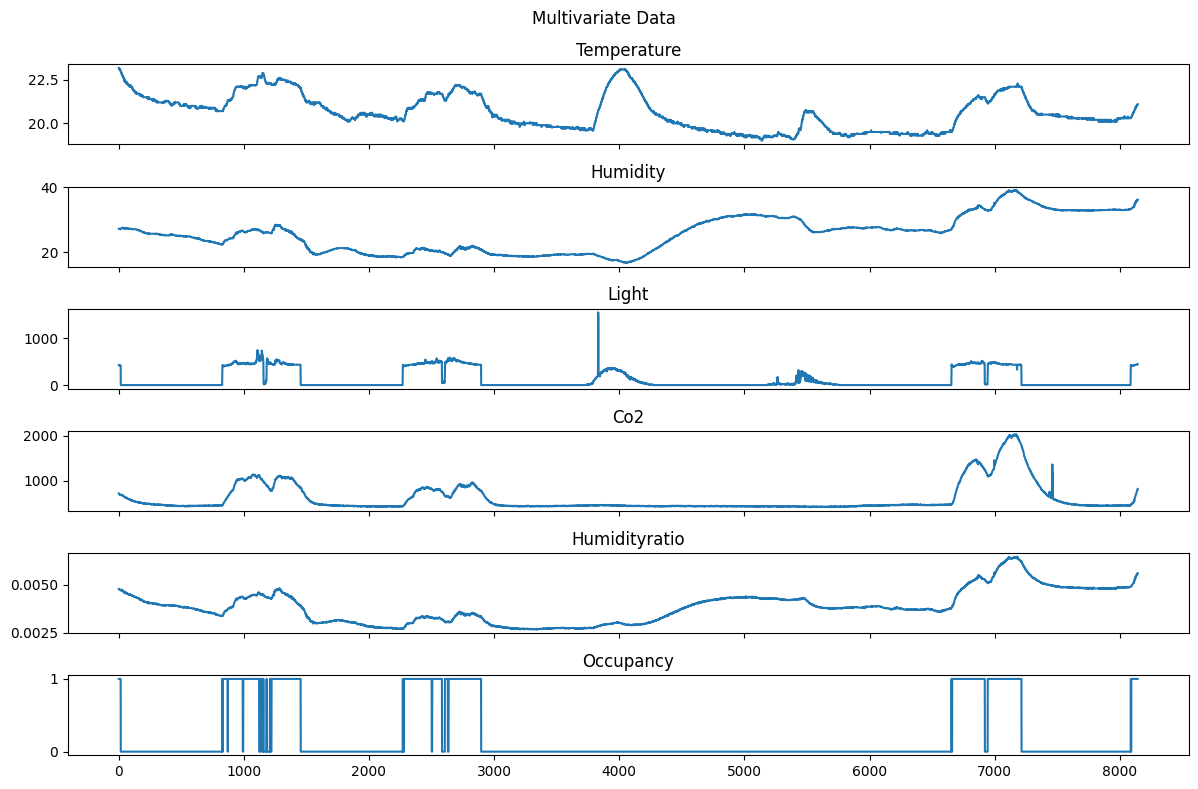

In [31]:
plot_multivariate_data(train_data_df)

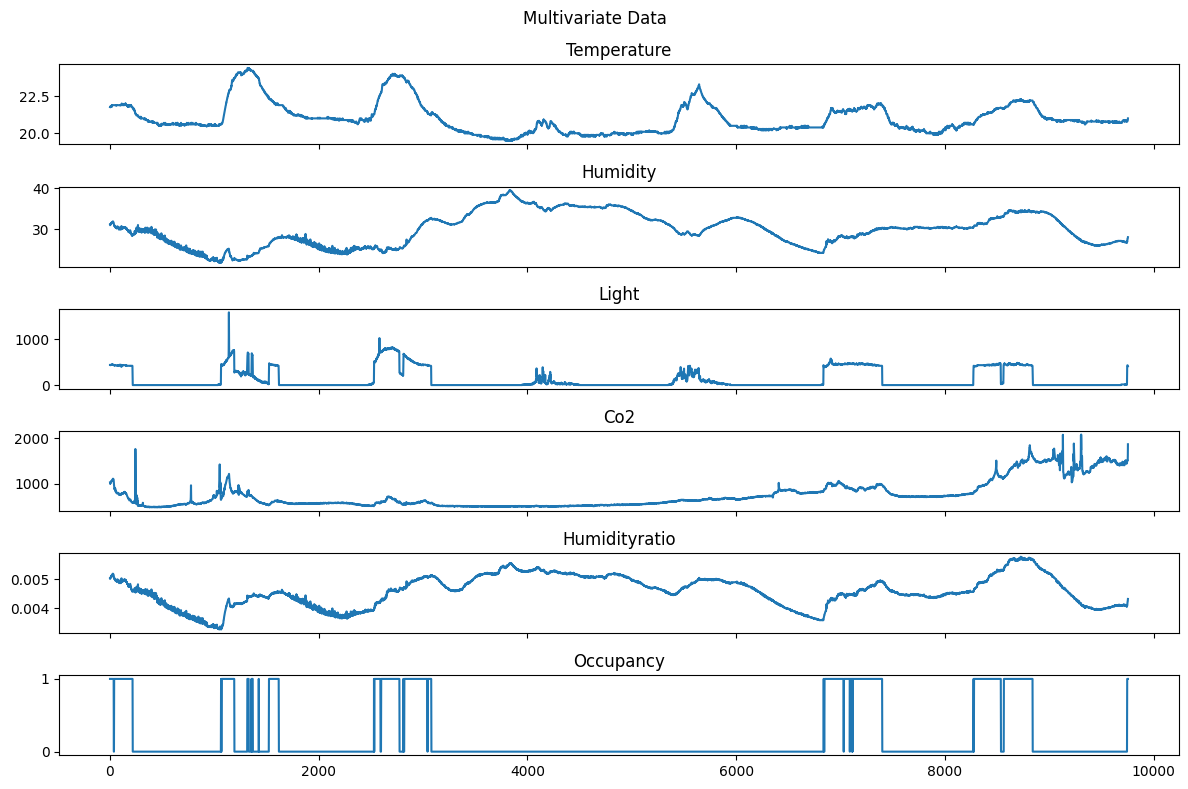

In [32]:
plot_multivariate_data(test_data_df)

#### Findings

After analyzing the data, it looks like the time ranges for the training set are all coming from the date range of February 4, 2015 - February 10, 2015, and the test set is coming from the date range of February 11, 2015 - February 18, 2015. That being said, a useful bit of information would to be encode the timestamps using a cyclical pattern for the hour of day to see if that helps predictions.

### Create Data

In [33]:
train_data_not_scaled = train_data_df.drop('id', axis=1).drop('date', axis=1).to_numpy()
test_data_not_scaled = test_data_df.drop('id', axis=1).drop('date', axis=1).to_numpy()

train_data_not_scaled[:4]

array([[2.31800000e+01, 2.72720000e+01, 4.26000000e+02, 7.21250000e+02,
        4.79298818e-03, 1.00000000e+00],
       [2.31500000e+01, 2.72675000e+01, 4.29500000e+02, 7.14000000e+02,
        4.78344095e-03, 1.00000000e+00],
       [2.31500000e+01, 2.72450000e+01, 4.26000000e+02, 7.13500000e+02,
        4.77946352e-03, 1.00000000e+00],
       [2.31500000e+01, 2.72000000e+01, 4.26000000e+02, 7.08250000e+02,
        4.77150883e-03, 1.00000000e+00]])

In [34]:
train_data_not_scaled[:4, :-1]

array([[2.31800000e+01, 2.72720000e+01, 4.26000000e+02, 7.21250000e+02,
        4.79298818e-03],
       [2.31500000e+01, 2.72675000e+01, 4.29500000e+02, 7.14000000e+02,
        4.78344095e-03],
       [2.31500000e+01, 2.72450000e+01, 4.26000000e+02, 7.13500000e+02,
        4.77946352e-03],
       [2.31500000e+01, 2.72000000e+01, 4.26000000e+02, 7.08250000e+02,
        4.77150883e-03]])

#### Cyclical Timestamp Data

Converting the hour of day timestamp to a cyclically encoded feature to used as a separate test case.

NOTE: This data should not be scaled, so instead of concatenating this data now, I am going to hold of to do this until creating the datasets.

In [35]:
train_cyclical_hours = cyclically_encode_timestamp(train_data_df.date.apply(lambda x: x.hour).to_numpy())
test_cyclical_hours = cyclically_encode_timestamp(test_data_df.date.apply(lambda x: x.hour).to_numpy())

train_cyclical_hours, test_cyclical_hours

(<tf.Tensor: shape=(8143, 2), dtype=float64, numpy=
 array([[-0.96592583, -0.25881905],
        [-0.96592583, -0.25881905],
        [-0.96592583, -0.25881905],
        ...,
        [ 0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678]])>,
 <tf.Tensor: shape=(9752, 2), dtype=float64, numpy=
 array([[-0.5       , -0.8660254 ],
        [-0.5       , -0.8660254 ],
        [-0.5       , -0.8660254 ],
        ...,
        [ 0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678]])>)

### Preprocess Data

In [36]:
min_max_scaler = MinMaxScaler()

min_max_scaler.fit(train_data_not_scaled[:, :-1])
min_max_scaler.data_max_

array([2.31800000e+01, 3.91175000e+01, 1.54633333e+03, 2.02850000e+03,
       6.47601324e-03])

In [37]:
train_data_no_occupancy = min_max_scaler.transform(train_data_not_scaled[:, :-1])
train_data = np.hstack((train_data_no_occupancy, train_data_not_scaled[:, -1].reshape((-1,1))))

test_data_no_occupancy = min_max_scaler.transform(test_data_not_scaled[:, :-1])
test_data = np.hstack((test_data_no_occupancy, test_data_not_scaled[:, -1].reshape((-1,1))))

train_data.shape, test_data.shape, train_data[:4]

((8143, 6),
 (9752, 6),
 array([[1.        , 0.47053302, 0.27549041, 0.190933  , 0.55731842,
         1.        ],
        [0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723,
         1.        ],
        [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106,
         1.        ],
        [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876,
         1.        ]]))

In [38]:
train_data_cyclical = tf.concat([train_data[:, :-1], train_cyclical_hours, train_data[:, -1:]], axis=1)
test_data_cyclical = tf.concat([test_data[:, :-1], test_cyclical_hours, test_data[:, -1:]], axis=1)

train_data_cyclical.shape, test_data_cyclical.shape, train_data_cyclical[:4]

(TensorShape([8143, 8]),
 TensorShape([9752, 8]),
 <tf.Tensor: shape=(4, 8), dtype=float64, numpy=
 array([[ 1.        ,  0.47053302,  0.27549041,  0.190933  ,  0.55731842,
         -0.96592583, -0.25881905,  1.        ],
        [ 0.99282297,  0.47033188,  0.27775383,  0.18644592,  0.55480723,
         -0.96592583, -0.25881905,  1.        ],
        [ 0.99282297,  0.46932618,  0.27549041,  0.18613647,  0.55376106,
         -0.96592583, -0.25881905,  1.        ],
        [ 0.99282297,  0.46731478,  0.27549041,  0.1828872 ,  0.55166876,
         -0.96592583, -0.25881905,  1.        ]])>)

### Create Datasets

In [39]:
train_dataset = make_windowed_dataset(train_data)
test_dataset = make_windowed_dataset(test_data)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [40]:
train_dataset_no_occ = make_windowed_dataset(train_data, include_occupancy=False)
test_dataset_no_occ = make_windowed_dataset(test_data, include_occupancy=False)

train_dataset_no_occ, test_dataset_no_occ

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [41]:
train_dataset_cyclical = make_windowed_dataset(train_data_cyclical, include_occupancy=True)
test_dataset_cyclical = make_windowed_dataset(test_data_cyclical, include_occupancy=True)

train_dataset_cyclical, test_dataset_cyclical

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [42]:
train_dataset_cyclical_no_occ = make_windowed_dataset(train_data_cyclical, include_occupancy=False)
test_dataset_cyclical_no_occ = make_windowed_dataset(test_data_cyclical, include_occupancy=False)

train_dataset_cyclical_no_occ, test_dataset_cyclical_no_occ

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [43]:
train_dataset_cyclical_no_occ_w14 = make_windowed_dataset(train_data_cyclical, window_size=14, include_occupancy=False)
test_dataset_cyclical_no_occ_w14 = make_windowed_dataset(test_data_cyclical, window_size=14, include_occupancy=False)

train_dataset_cyclical_no_occ_w14, test_dataset_cyclical_no_occ_w14

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [44]:
train_dataset_cyclical_no_occ_w2 = make_windowed_dataset(train_data_cyclical, window_size=2, include_occupancy=False)
test_dataset_cyclical_no_occ_w2 = make_windowed_dataset(test_data_cyclical, window_size=2, include_occupancy=False)

train_dataset_cyclical_no_occ_w2, test_dataset_cyclical_no_occ_w2

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

#### Verify Datasets Split Correctly

In [45]:
example_data, example_labels = next(iter(train_dataset.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 7, 6), dtype=float64, numpy=
 array([[[1.        , 0.47053302, 0.27549041, 0.190933  , 0.55731842,
          1.        ],
         [0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723,
          1.        ],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106,
          1.        ],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876,
          1.        ],
         [0.98086124, 0.46731478, 0.27549041, 0.1805663 , 0.54785068,
          1.        ],
         [0.98086124, 0.46731478, 0.27096357, 0.17840012, 0.54785068,
          1.        ],
         [0.98086124, 0.46731478, 0.27096357, 0.17881273, 0.54785068,
          1.        ]],
 
        [[0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723,
          1.        ],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106,
          1.        ],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876,
          1.        ],
         [0.980

In [46]:
example_data, example_labels = next(iter(train_dataset_no_occ.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 7, 5), dtype=float64, numpy=
 array([[[1.        , 0.47053302, 0.27549041, 0.190933  , 0.55731842],
         [0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876],
         [0.98086124, 0.46731478, 0.27549041, 0.1805663 , 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17840012, 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17881273, 0.54785068]],
 
        [[0.99282297, 0.47033188, 0.27775383, 0.18644592, 0.55480723],
         [0.99282297, 0.46932618, 0.27549041, 0.18613647, 0.55376106],
         [0.99282297, 0.46731478, 0.27549041, 0.1828872 , 0.55166876],
         [0.98086124, 0.46731478, 0.27549041, 0.1805663 , 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17840012, 0.54785068],
         [0.98086124, 0.46731478, 0.27096357, 0.17881273, 0.54785068],
         [0.98086124, 

In [47]:
example_data, example_labels = next(iter(train_dataset_cyclical.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 7, 8), dtype=float64, numpy=
 array([[[ 1.        ,  0.47053302,  0.27549041,  0.190933  ,
           0.55731842, -0.96592583, -0.25881905,  1.        ],
         [ 0.99282297,  0.47033188,  0.27775383,  0.18644592,
           0.55480723, -0.96592583, -0.25881905,  1.        ],
         [ 0.99282297,  0.46932618,  0.27549041,  0.18613647,
           0.55376106, -0.96592583, -0.25881905,  1.        ],
         [ 0.99282297,  0.46731478,  0.27549041,  0.1828872 ,
           0.55166876, -0.96592583, -0.25881905,  1.        ],
         [ 0.98086124,  0.46731478,  0.27549041,  0.1805663 ,
           0.54785068, -0.96592583, -0.25881905,  1.        ],
         [ 0.98086124,  0.46731478,  0.27096357,  0.17840012,
           0.54785068, -0.96592583, -0.25881905,  1.        ],
         [ 0.98086124,  0.46731478,  0.27096357,  0.17881273,
           0.54785068, -0.96592583, -0.25881905,  1.        ]],
 
        [[ 0.99282297,  0.47033188,  0.27775383,  0.18644592,
        

In [48]:
example_data, example_labels = next(iter(train_dataset_cyclical_no_occ.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 7, 7), dtype=float64, numpy=
 array([[[ 1.        ,  0.47053302,  0.27549041,  0.190933  ,
           0.55731842, -0.96592583, -0.25881905],
         [ 0.99282297,  0.47033188,  0.27775383,  0.18644592,
           0.55480723, -0.96592583, -0.25881905],
         [ 0.99282297,  0.46932618,  0.27549041,  0.18613647,
           0.55376106, -0.96592583, -0.25881905],
         [ 0.99282297,  0.46731478,  0.27549041,  0.1828872 ,
           0.55166876, -0.96592583, -0.25881905],
         [ 0.98086124,  0.46731478,  0.27549041,  0.1805663 ,
           0.54785068, -0.96592583, -0.25881905],
         [ 0.98086124,  0.46731478,  0.27096357,  0.17840012,
           0.54785068, -0.96592583, -0.25881905],
         [ 0.98086124,  0.46731478,  0.27096357,  0.17881273,
           0.54785068, -0.96592583, -0.25881905]],
 
        [[ 0.99282297,  0.47033188,  0.27775383,  0.18644592,
           0.55480723, -0.96592583, -0.25881905],
         [ 0.99282297,  0.46932618,  0.27549041, 

In [49]:
example_data, example_labels = next(iter(train_dataset_cyclical_no_occ_w14.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 14, 7), dtype=float64, numpy=
 array([[[ 1.00000000e+00,  4.70533020e-01,  2.75490407e-01,
           1.90933003e-01,  5.57318416e-01, -9.65925826e-01,
          -2.58819045e-01],
         [ 9.92822967e-01,  4.70331881e-01,  2.77753826e-01,
           1.86445923e-01,  5.54807234e-01, -9.65925826e-01,
          -2.58819045e-01],
         [ 9.92822967e-01,  4.69326182e-01,  2.75490407e-01,
           1.86136469e-01,  5.53761063e-01, -9.65925826e-01,
          -2.58819045e-01],
         [ 9.92822967e-01,  4.67314784e-01,  2.75490407e-01,
           1.82887204e-01,  5.51668760e-01, -9.65925826e-01,
          -2.58819045e-01],
         [ 9.80861244e-01,  4.67314784e-01,  2.75490407e-01,
           1.80566300e-01,  5.47850683e-01, -9.65925826e-01,
          -2.58819045e-01],
         [ 9.80861244e-01,  4.67314784e-01,  2.70963570e-01,
           1.78400124e-01,  5.47850683e-01, -9.65925826e-01,
          -2.58819045e-01],
         [ 9.80861244e-01,  4.67314784e-01,  2.

In [50]:
example_data, example_labels = next(iter(train_dataset_cyclical_no_occ_w2.take(1)))
example_data[:2], example_labels[:2]

(<tf.Tensor: shape=(2, 2, 7), dtype=float64, numpy=
 array([[[ 1.        ,  0.47053302,  0.27549041,  0.190933  ,
           0.55731842, -0.96592583, -0.25881905],
         [ 0.99282297,  0.47033188,  0.27775383,  0.18644592,
           0.55480723, -0.96592583, -0.25881905]],
 
        [[ 0.99282297,  0.47033188,  0.27775383,  0.18644592,
           0.55480723, -0.96592583, -0.25881905],
         [ 0.99282297,  0.46932618,  0.27549041,  0.18613647,
           0.55376106, -0.96592583, -0.25881905]]])>,
 <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>)

## Experiments

I am going to perform a handful of experiments to see if I can predict whether a room is occupied or not.

* Experiment-0 (Baseline): Naive Model
* Experiment-1: Feed Forward Model (Windows=7, All Data)
* Experiment-2: Single LSTM (Windows=7, All Data)
* Experiment-3: Single LSTM (Windows=7, No Occupancy Knowledge)
* Experiment-4: Single Bidirectional LSTM (Window=7, No Occupancy Knowledge)
* Experiment-5: Conv1D (Window=7, No Occupancy Knowledge)¶
* Experiment-6: Ensemble (Window=7, No Occupancy Knowledge)
* Experiment-7: Single LSTM (Windows=7, Cyclical Hour w/ No Occupancy Knowledge)
* Experiment-8: Double LSTM (Windows=7, Cyclical Hour w/ No Occupancy Knowledge)
* Experiment-9: Double LSTM (Windows=14, Cyclical Hour w/ No Occupancy Knowledge)
* Experiment-10: Double LSTM (Windows=2, Cyclical Hour w/ No Occupancy Knowledge)
* Experiment-11: LSTM To Outperform Naive (Windows=7, Cyclical Hour w/ Occupancy Knowledge)

### Constants

In [51]:
INPUT_SHAPE = (7, 6)  # Window of 7 with 6 attributes each window
INPUT_SHAPE_CYCLICAL = (7, 8)
INPUT_SHAPE_NO_OCCUPANCY = (7, 5)
INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY = (7, 7)
INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY_W14 = (14, 7)
INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY_W2 = (2, 7)

OUTPUT_SIZE = 1

### Experiment-0: Naive

In [52]:
# Constants
model_0_name = 'model_0_naive'

In [53]:
naive_forecast = test_data[:-1, -1]

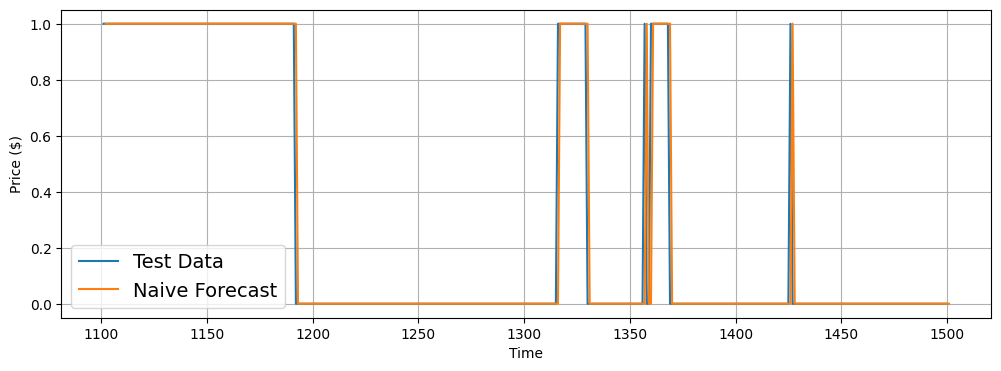

In [54]:
# Data Visualization
plot_occupancy_pred_vs_true(naive_forecast, test_data_df, 1100, 1500, 'Naive Forecast')

In [55]:
model_0_results = ml_toolbox.analysis.classification.generate_prediction_metrics(test_data[1:, -1], naive_forecast, name=model_0_name)
model_0_results

ClassificationPredictionMetrics(accuracy=0.9950774279561071, precision=0.9950774279561071, recall=0.9950774279561071, f1=0.9950774279561071, name='model_0_naive')

### Experiment-1: Feed Forward Model (Windows=7, All Data)

In [56]:
# Constants
model_1_name = 'model_1_ff'

In [57]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid'),
], name=model_1_name)

model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model_1_history = model_1.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 1s 4ms/step - loss: 0.4966 - accuracy: 0.8815 - val_loss: 0.1163 - val_accuracy: 0.9881
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0722 - accuracy: 0.9881 - val_loss: 0.0386 - val_accuracy: 0.9895
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0410 - accuracy: 0.9889 - val_loss: 0.0343 - val_accuracy: 0.9903
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0363 - accuracy: 0.9903 - val_loss: 0.0322 - val_accuracy: 0.9918
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0336 - accuracy: 0.9916 - val_loss: 0.0303 - val_accuracy: 0.9927
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0313 - accuracy: 0.9921 - val_loss: 0.0286 - val_accuracy: 0.9929
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0294 - accuracy: 0.9925 - val_loss: 0.0273 - val_accuracy: 0.9931
Epoch 

In [58]:
model_1.summary()

Model: "model_1_ff"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7, 32)             224       
                                                                 
 dense_1 (Dense)             (None, 7, 16)             528       
                                                                 
 dense_2 (Dense)             (None, 7, 8)              136       
                                                                 
 flatten (Flatten)           (None, 56)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 57        
                                                                 
Total params: 945 (3.69 KB)
Trainable params: 945 (3.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
model_1_preds = make_predictions(model_1, test_dataset)
model_1_preds[:5]

305/305 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 1, 1], dtype=int32)>

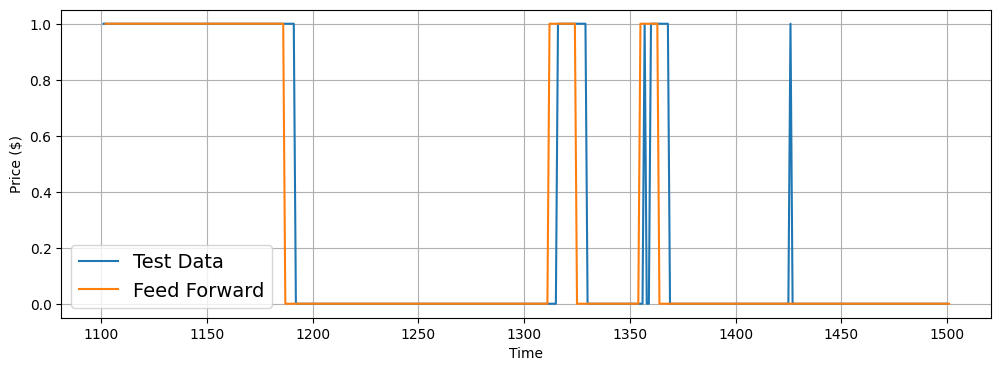

In [60]:
# Data Visualization
plot_occupancy_pred_vs_true(model_1_preds, test_data_df, 1100, 1500, 'Feed Forward')

In [61]:
model_1_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_1)
model_1_results

ClassificationPredictionMetrics(accuracy=0.9945613134940995, precision=0.9945571987134206, recall=0.9945613134940995, f1=0.9945588624220651, name='model_1_ff')

### Experiment-2: Single LSTM (Window=7, All Data)

In [62]:
# constants
model_2_name = 'model_2_lstm_w7'

In [63]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)

model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_2_history = model_2.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 2s 4ms/step - loss: 0.3986 - accuracy: 0.8724 - val_loss: 0.1072 - val_accuracy: 0.9872
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0772 - accuracy: 0.9850 - val_loss: 0.0615 - val_accuracy: 0.9859
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0633 - accuracy: 0.9846 - val_loss: 0.0579 - val_accuracy: 0.9860
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0596 - accuracy: 0.9848 - val_loss: 0.0549 - val_accuracy: 0.9868
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0566 - accuracy: 0.9849 - val_loss: 0.0528 - val_accuracy: 0.9869
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0541 - accuracy: 0.9848 - val_loss: 0.0508 - val_accuracy: 0.9871
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0513 - accuracy: 0.9848 - val_loss: 0.0487 - val_accuracy: 0.9876
Epoch 

In [64]:
model_2.summary()

Model: "model_2_lstm_w7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1489 (5.82 KB)
Trainable params: 1489 (5.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


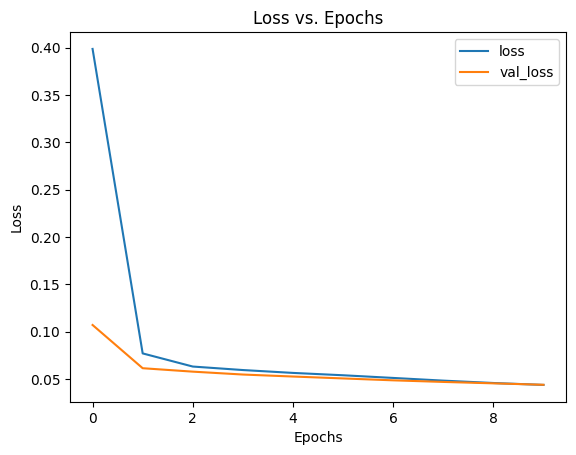

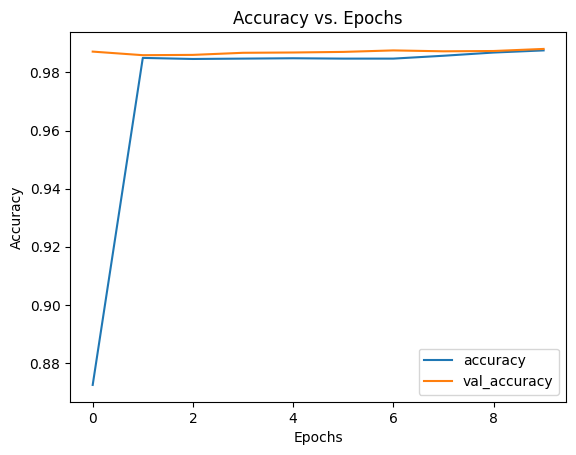

In [65]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_2_history, 'accuracy')

In [66]:
model_2_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset, model_2)
model_2_results

ClassificationPredictionMetrics(accuracy=0.9880964597229348, precision=0.9881155270260272, recall=0.9880964597229348, f1=0.9881050034069524, name='model_2_lstm_w7')

### Experiment-3: Single LSTM (Window=7, No Occupancy Knowledge)

In [67]:
# Constants
model_3_name = 'model_3_lstm_w7_no_occ'

In [68]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_NO_OCCUPANCY)
x = tf.keras.layers.LSTM(16)(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_3_history = model_3.fit(
    train_dataset_no_occ,
    validation_data=test_dataset_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 2s 4ms/step - loss: 0.5749 - accuracy: 0.7938 - val_loss: 0.3605 - val_accuracy: 0.9031
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.2060 - accuracy: 0.9441 - val_loss: 0.2553 - val_accuracy: 0.8991
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1349 - accuracy: 0.9673 - val_loss: 0.3302 - val_accuracy: 0.8670
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1153 - accuracy: 0.9694 - val_loss: 0.2309 - val_accuracy: 0.9186
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0960 - accuracy: 0.9738 - val_loss: 0.1541 - val_accuracy: 0.9401
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0850 - accuracy: 0.9796 - val_loss: 0.0790 - val_accuracy: 0.9785
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0794 - accuracy: 0.9811 - val_loss: 0.0634 - val_accuracy: 0.9877
Epoch 

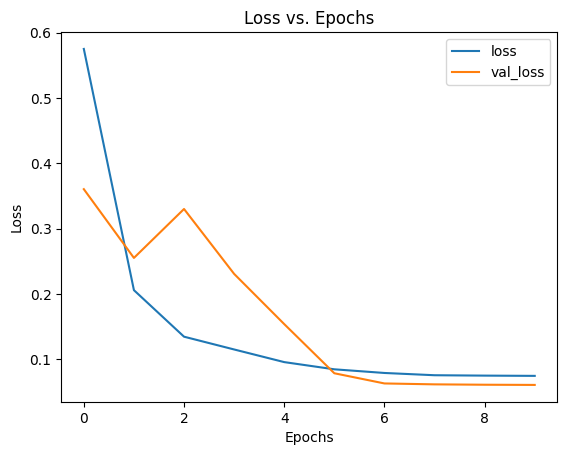

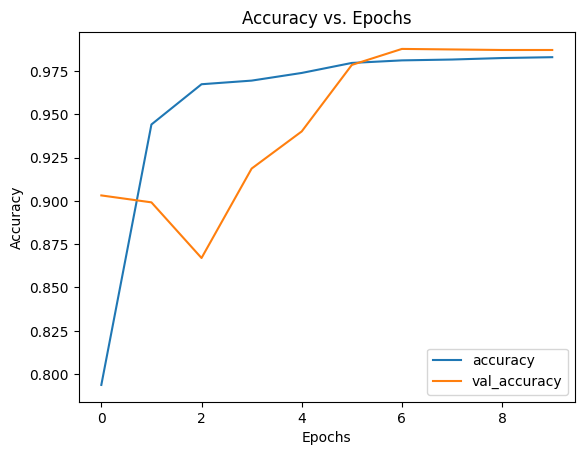

In [69]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_3_history, 'accuracy')

In [70]:
model_3_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_no_occ, model_3)
model_3_results

ClassificationPredictionMetrics(accuracy=0.9870702924576706, precision=0.9871838146756405, recall=0.9870702924576706, f1=0.9871093700516115, name='model_3_lstm_w7_no_occ')

### Experiment-4: Single Bidirectional LSTM (Window=7, No Occupancy Knowledge)

In [71]:
# Constants
model_4_name = 'model_4_bidirect_lstm_w7_no_occ'

In [72]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_NO_OCCUPANCY)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_4 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_4_history = model_4.fit(
    train_dataset_no_occ,
    validation_data=test_dataset_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 3s 5ms/step - loss: 0.5730 - accuracy: 0.7971 - val_loss: 0.3376 - val_accuracy: 0.8963
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1808 - accuracy: 0.9562 - val_loss: 0.4246 - val_accuracy: 0.8277
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1185 - accuracy: 0.9683 - val_loss: 0.3261 - val_accuracy: 0.8653
Epoch 4/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0781 - accuracy: 0.9822 - val_loss: 0.1029 - val_accuracy: 0.9631
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0646 - accuracy: 0.9854 - val_loss: 0.0489 - val_accuracy: 0.9888
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0611 - accuracy: 0.9859 - val_loss: 0.0377 - val_accuracy: 0.9931
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.0597 - accuracy: 0.9859 - val_loss: 0.0357 - val_accuracy: 0.9931
Epoch 

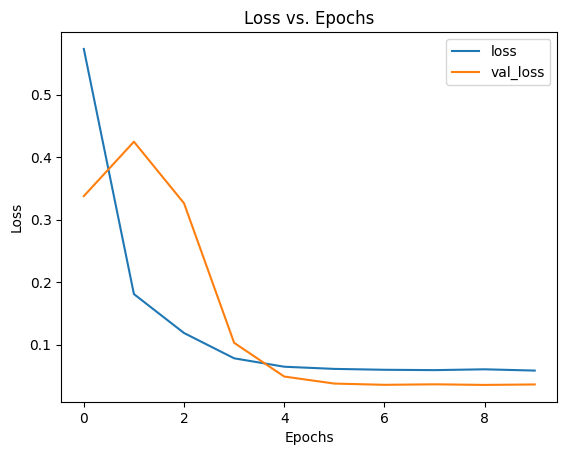

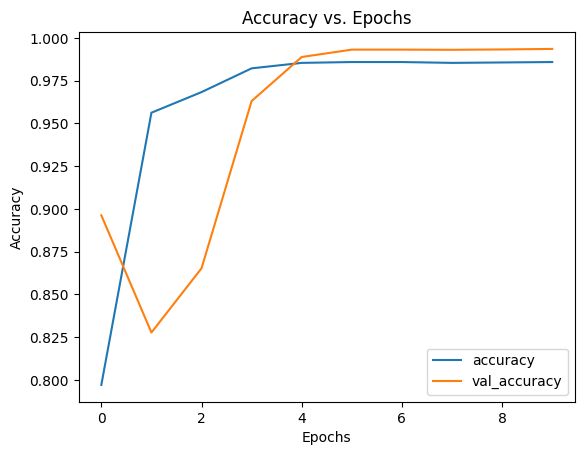

In [73]:
ml_toolbox.analysis.history.plot_history(model_4_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_4_history, 'accuracy')

In [74]:
model_4_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_no_occ, model_4)
model_4_results

ClassificationPredictionMetrics(accuracy=0.9935351462288353, precision=0.993563815873956, recall=0.9935351462288353, f1=0.9935449748922667, name='model_3_lstm_w7_no_occ')

### Experiment-5: Conv1D (Window=7, No Occupancy Knowledge)

In [75]:
# Constants
model_5_name = 'model_5_conv_w7_no_occ'

In [76]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_NO_OCCUPANCY)
x = tf.keras.layers.Conv1D(32, 3)(inputs)
x = tf.keras.layers.Conv1D(16, 3)(inputs)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_5 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_5_history = model_5.fit(
    train_dataset_no_occ,
    validation_data=test_dataset_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 1s 3ms/step - loss: 0.6434 - accuracy: 0.7613 - val_loss: 0.4706 - val_accuracy: 0.7979
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.4449 - accuracy: 0.8419 - val_loss: 0.3874 - val_accuracy: 0.8659
Epoch 3/10
255/255 [==============================] - 1s 3ms/step - loss: 0.2963 - accuracy: 0.9313 - val_loss: 0.3059 - val_accuracy: 0.8746
Epoch 4/10
255/255 [==============================] - 1s 2ms/step - loss: 0.2034 - accuracy: 0.9572 - val_loss: 0.2588 - val_accuracy: 0.8838
Epoch 5/10
255/255 [==============================] - 1s 2ms/step - loss: 0.1563 - accuracy: 0.9612 - val_loss: 0.2334 - val_accuracy: 0.8918
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1321 - accuracy: 0.9639 - val_loss: 0.2137 - val_accuracy: 0.9006
Epoch 7/10
255/255 [==============================] - 1s 2ms/step - loss: 0.1177 - accuracy: 0.9666 - val_loss: 0.1957 - val_accuracy: 0.9108
Epoch 

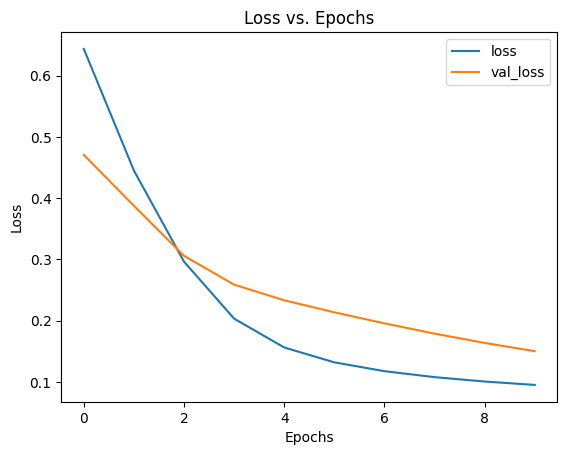

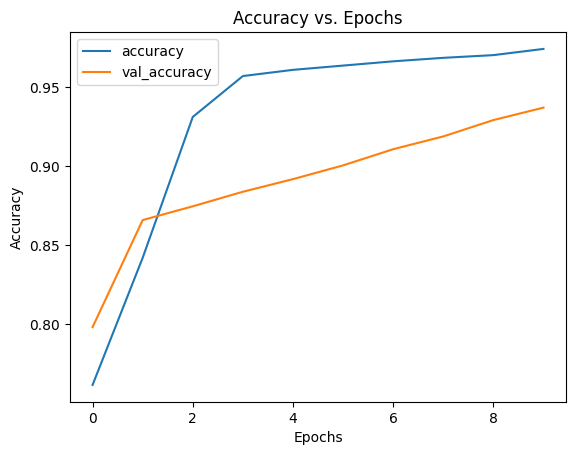

In [77]:
ml_toolbox.analysis.history.plot_history(model_5_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_5_history, 'accuracy')

In [78]:
model_5_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_no_occ, model_5)
model_5_results

ClassificationPredictionMetrics(accuracy=0.9371985633658286, precision=0.9373567029723562, recall=0.9371985633658286, f1=0.934447698421148, name='model_3_lstm_w7_no_occ')

### Experiment-6: Ensemble (Window=7, No Occupancy Knowledge)¶

In [79]:
# Constants
model_6_name = 'model_6_ensemble'

In [80]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

# Build, Compile, and Fit Models
ensemble_models = get_ensemble_models(input_shape=INPUT_SHAPE_NO_OCCUPANCY,
                                      train_data=train_dataset_no_occ,
                                      test_data=test_dataset_no_occ,
                                      num_iter=5,
                                      num_epochs=10)

Optimizing model by reducing: for 10, model number: 0
Optimizing model by reducing: for 10, model number: 1
Optimizing model by reducing: for 10, model number: 2
Optimizing model by reducing: for 10, model number: 3
Optimizing model by reducing: for 10, model number: 4


In [81]:
model_6_mean_results, model_6_median_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_models(
    test_dataset_no_occ, ensemble_models, model_6_name)

model_6_mean_results, model_6_median_results

(ClassificationPredictionMetrics(accuracy=0.9559774243201642, precision=0.9573712249058718, recall=0.9559774243201642, f1=0.9542439084404453, name='model_6_ensemble_mean'),
 ClassificationPredictionMetrics(accuracy=0.9773217034376603, precision=0.9774240811595825, recall=0.9773217034376603, f1=0.9769873182780416, name='model_6_ensemble_median'))

### Experiment-7: Single LSTM (Window=7, Cyclical Hour, No Occupancy Knowledge)

In [82]:
# constants
model_7_name = 'model_7_lstm_w7_cyc_no_occ'

In [83]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY)
x = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_7 = tf.keras.models.Model(inputs, outputs, name=model_7_name)

model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics='accuracy')

model_7_history = model_7.fit(
    train_dataset_cyclical_no_occ,
    validation_data=test_dataset_cyclical_no_occ,
    epochs=10)

Epoch 1/10
255/255 [==============================] - 2s 4ms/step - loss: 0.6356 - accuracy: 0.7655 - val_loss: 0.3710 - val_accuracy: 0.8532
Epoch 2/10
255/255 [==============================] - 1s 3ms/step - loss: 0.3347 - accuracy: 0.8555 - val_loss: 0.2921 - val_accuracy: 0.8525
Epoch 3/10
255/255 [==============================] - 1s 4ms/step - loss: 0.2273 - accuracy: 0.9110 - val_loss: 0.2793 - val_accuracy: 0.8761
Epoch 4/10
255/255 [==============================] - 1s 4ms/step - loss: 0.1820 - accuracy: 0.9178 - val_loss: 0.2802 - val_accuracy: 0.9015
Epoch 5/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1599 - accuracy: 0.9310 - val_loss: 0.2530 - val_accuracy: 0.9072
Epoch 6/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1273 - accuracy: 0.9529 - val_loss: 0.2669 - val_accuracy: 0.9041
Epoch 7/10
255/255 [==============================] - 1s 3ms/step - loss: 0.1102 - accuracy: 0.9673 - val_loss: 0.2195 - val_accuracy: 0.9165
Epoch 

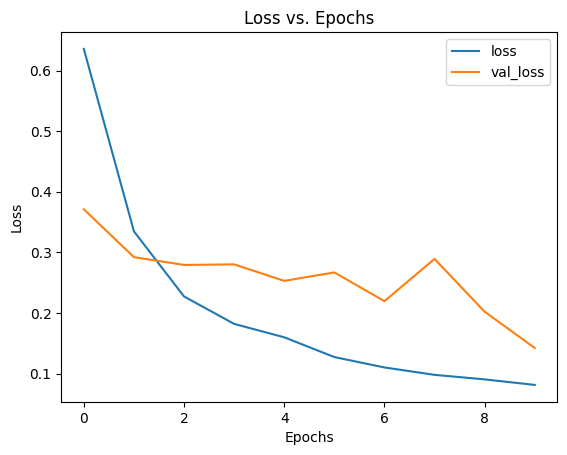

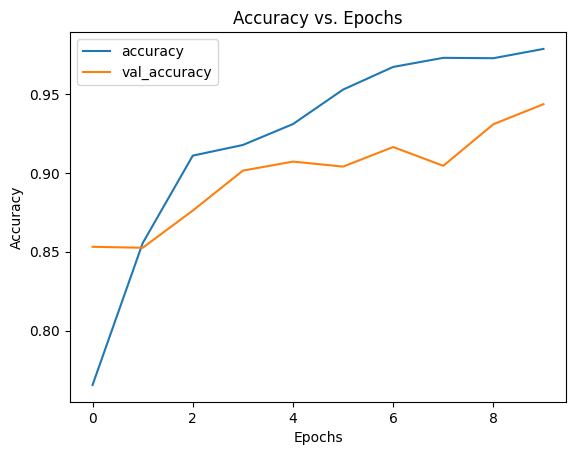

In [84]:
ml_toolbox.analysis.history.plot_history(model_7_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_7_history, 'accuracy')

In [85]:
model_7_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_cyclical_no_occ, model_7)
model_7_results

ClassificationPredictionMetrics(accuracy=0.9436634171369933, precision=0.945363421463412, recall=0.9436634171369933, f1=0.9442880615285709, name='model_7_lstm_w7_cyc_no_occ')

#### Findings

After looking at the loss and accuracy curves, the data seems to be jumpy. To help fix this, I am going to introduce a batch normalization layer in Experiment-8, as well as stacking two LSTM layers to see if that helps improve the model.

### Experiment-8: Double LSTM (Window=7, Cyclical Hour, No Occupancy Knowledge)

In [86]:
# constants
model_8_name = 'model_8_double_lstm_w7_cyc_no_occ'

In [87]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY)
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(64)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_8 = tf.keras.models.Model(inputs, outputs, name=model_8_name)

model_8.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics='accuracy')

model_8_history = model_8.fit(
    train_dataset_cyclical_no_occ,
    validation_data=test_dataset_cyclical_no_occ,
    epochs=15)

Epoch 1/15
255/255 [==============================] - 2s 4ms/step - loss: 0.6700 - accuracy: 0.7196 - val_loss: 0.6204 - val_accuracy: 0.9110
Epoch 2/15
255/255 [==============================] - 1s 3ms/step - loss: 0.6301 - accuracy: 0.7912 - val_loss: 0.4777 - val_accuracy: 0.9744
Epoch 3/15
255/255 [==============================] - 1s 3ms/step - loss: 0.5977 - accuracy: 0.7936 - val_loss: 0.3001 - val_accuracy: 0.9759
Epoch 4/15
255/255 [==============================] - 1s 4ms/step - loss: 0.5709 - accuracy: 0.7947 - val_loss: 0.2313 - val_accuracy: 0.9831
Epoch 5/15
255/255 [==============================] - 1s 3ms/step - loss: 0.5502 - accuracy: 0.7956 - val_loss: 0.2051 - val_accuracy: 0.9866
Epoch 6/15
255/255 [==============================] - 1s 3ms/step - loss: 0.5355 - accuracy: 0.7956 - val_loss: 0.1892 - val_accuracy: 0.9890
Epoch 7/15
255/255 [==============================] - 1s 3ms/step - loss: 0.5255 - accuracy: 0.7958 - val_loss: 0.1778 - val_accuracy: 0.9907
Epoch 

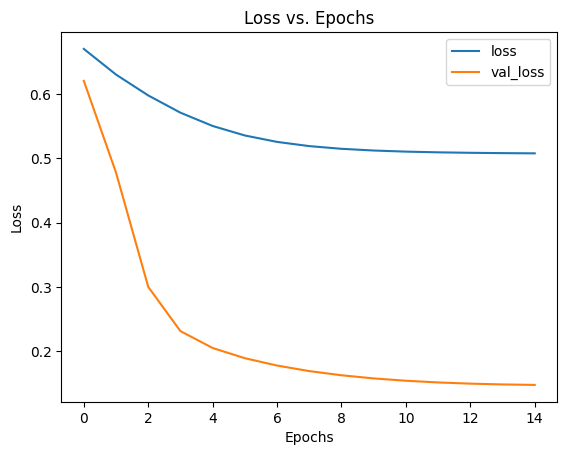

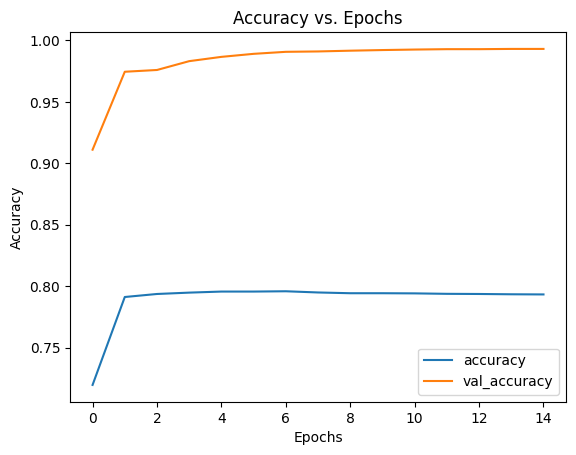

In [88]:
ml_toolbox.analysis.history.plot_history(model_8_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_8_history, 'accuracy')

In [89]:
model_8_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(test_dataset_cyclical_no_occ, model_8)
model_8_results

ClassificationPredictionMetrics(accuracy=0.9930220625962032, precision=0.9930754014940033, recall=0.9930220625962032, f1=0.9930382358045129, name='model_8_double_lstm_w7_cyc_no_occ')

#### Findings

Introducing the stacked layers definitely improve accuracy, but I ended up having to lower the learning rate significantly in order for it to stabilize. There was no need to introduce an Early Stopping Callback or a Learning Rate scheduler because the model was fitting in a short amount of time.

### Experiment-9: Double LSTM (Window=14, Cyclical Hour, No Occupancy Knowledge)

In [90]:
# constants
model_9_name = 'model_9_double_lstm_w14_cyc_no_occ'

In [91]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY_W14)
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(64)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_9 = tf.keras.models.Model(inputs, outputs, name=model_9_name)

model_9.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00001),
                metrics='accuracy')

model_9_history = model_9.fit(
    train_dataset_cyclical_no_occ_w14,
    validation_data=test_dataset_cyclical_no_occ_w14,
    epochs=25)

Epoch 1/25
255/255 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5656 - val_loss: 0.6972 - val_accuracy: 0.4627
Epoch 2/25
255/255 [==============================] - 1s 5ms/step - loss: 0.6862 - accuracy: 0.6369 - val_loss: 0.7052 - val_accuracy: 0.4720
Epoch 3/25
255/255 [==============================] - 1s 5ms/step - loss: 0.6807 - accuracy: 0.6559 - val_loss: 0.6653 - val_accuracy: 0.5721
Epoch 4/25
255/255 [==============================] - 1s 5ms/step - loss: 0.6759 - accuracy: 0.6729 - val_loss: 0.5834 - val_accuracy: 0.6305
Epoch 5/25
255/255 [==============================] - 1s 5ms/step - loss: 0.6714 - accuracy: 0.6933 - val_loss: 0.5352 - val_accuracy: 0.7234
Epoch 6/25
255/255 [==============================] - 1s 5ms/step - loss: 0.6671 - accuracy: 0.7190 - val_loss: 0.5103 - val_accuracy: 0.7869
Epoch 7/25
255/255 [==============================] - 1s 5ms/step - loss: 0.6630 - accuracy: 0.7419 - val_loss: 0.4960 - val_accuracy: 0.8387
Epoch 

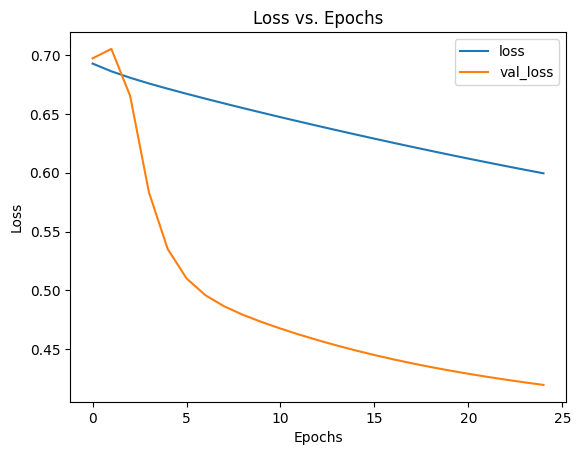

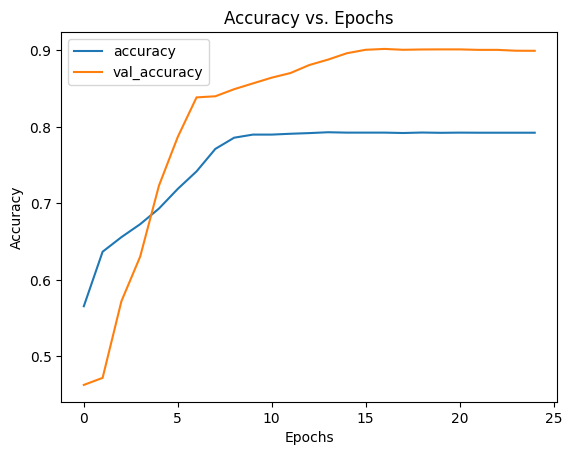

In [92]:
ml_toolbox.analysis.history.plot_history(model_9_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_9_history, 'accuracy')

In [93]:
model_9_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(
    test_dataset_cyclical_no_occ_w14, model_9)
model_9_results

ClassificationPredictionMetrics(accuracy=0.8995686999383857, precision=0.9150707015995072, recall=0.8995686999383857, f1=0.9037721936065802, name='model_9_double_lstm_w14_cyc_no_occ')

#### Findings

This model performed significantly worse the Experiment-8, implying that a lower time window would result in a more accurate prediction. To test this, I will run another experiment with a window size of 2 to see how it performs.

NOTE: Similarly to Experiment-8, the accuracy peaked and began going down, requiring me to reduce the learning rate by a factor of 10 again.

### Experiment-10: Double LSTM (Window=2, Cyclical Hour, No Occupancy Knowledge)

In [94]:
# Constants
model_10_name = 'model_10_double_lstm_w2_cyc_no_occ'

In [95]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_CYCLICAL_NO_OCCUPANCY_W2)
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(64)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_10 = tf.keras.models.Model(inputs, outputs, name=model_10_name)

model_10.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics='accuracy')

model_10_history = model_10.fit(
    train_dataset_cyclical_no_occ_w2,
    validation_data=test_dataset_cyclical_no_occ_w2,
    epochs=25)

Epoch 1/25
255/255 [==============================] - 2s 3ms/step - loss: 0.6716 - accuracy: 0.7166 - val_loss: 0.6451 - val_accuracy: 0.7984
Epoch 2/25
255/255 [==============================] - 1s 3ms/step - loss: 0.6310 - accuracy: 0.7979 - val_loss: 0.5546 - val_accuracy: 0.9643
Epoch 3/25
255/255 [==============================] - 1s 3ms/step - loss: 0.5964 - accuracy: 0.7987 - val_loss: 0.4352 - val_accuracy: 0.9065
Epoch 4/25
255/255 [==============================] - 1s 3ms/step - loss: 0.5681 - accuracy: 0.7986 - val_loss: 0.3622 - val_accuracy: 0.9241
Epoch 5/25
255/255 [==============================] - 1s 3ms/step - loss: 0.5469 - accuracy: 0.7976 - val_loss: 0.3081 - val_accuracy: 0.9433
Epoch 6/25
255/255 [==============================] - 1s 3ms/step - loss: 0.5322 - accuracy: 0.7971 - val_loss: 0.2669 - val_accuracy: 0.9507
Epoch 7/25
255/255 [==============================] - 1s 2ms/step - loss: 0.5225 - accuracy: 0.7968 - val_loss: 0.2365 - val_accuracy: 0.9567
Epoch 

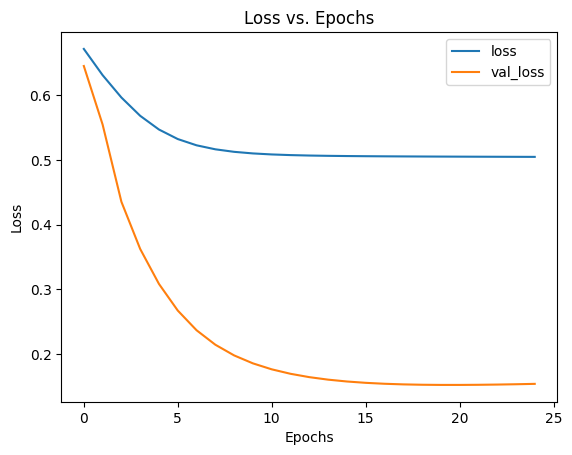

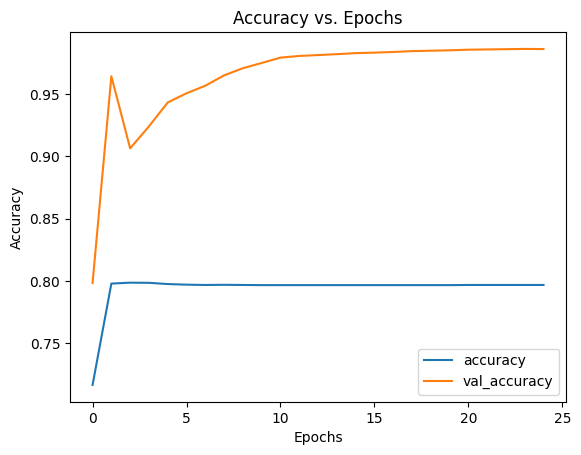

In [96]:
ml_toolbox.analysis.history.plot_history(model_10_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_10_history, 'accuracy')

In [97]:
model_10_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(
    test_dataset_cyclical_no_occ_w2, model_10)
model_10_results

ClassificationPredictionMetrics(accuracy=0.9861538461538462, precision=0.986767313727696, recall=0.9861538461538462, f1=0.9862840572994682, name='model_10_double_lstm_w2_cyc_no_occ')

#### Findings

After running Experiment-9 and Experiment-10, lower window size and higher window sizes result in less accurate predictions that a window size of 7 (not stating that window size of 7 is the magic number). This implies, that there is a potential optimum window size that could be used, however, this notebook will not dig into that test.

### Experiment-11: Optimized LSTM to Outperform Naive (Window=7, Cyclical Hour, Occupancy Knowledge)

This experiment is to simply see what it takes to actually (if possible) outperform the Naive model (Experiment-0).

In [98]:
# Constants
model_11_name = 'model_11_best_cyc_occ'

In [110]:
tf.keras.utils.set_random_seed(RANDOM_SEED)

inputs = tf.keras.layers.Input(shape=INPUT_SHAPE_CYCLICAL)
x = tf.keras.layers.LSTM(1024, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(512, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(256, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(256)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='sigmoid')(x)

model_11 = tf.keras.models.Model(inputs, outputs, name=model_11_name)

model_11.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                metrics='accuracy')

model_11_history = model_11.fit(
    train_dataset_cyclical,
    validation_data=test_dataset_cyclical,
    epochs=40,
    verbose=0,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=10, min_lr=1e-6),
    ])

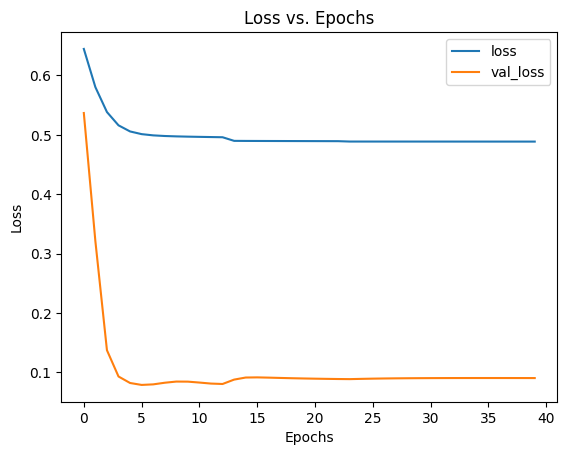

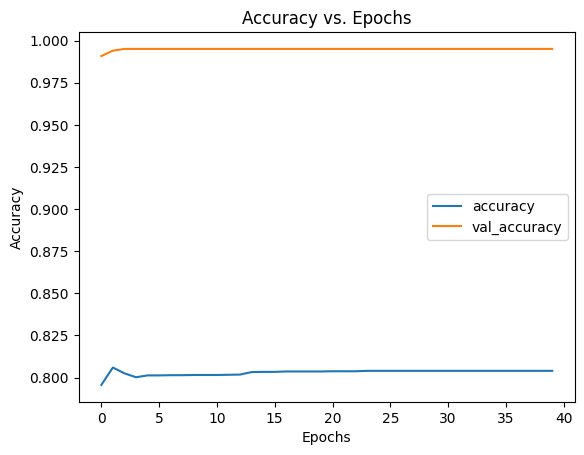

In [111]:
ml_toolbox.analysis.history.plot_history(model_11_history, 'loss')
ml_toolbox.analysis.history.plot_history(model_11_history, 'accuracy')

In [112]:
model_11_results = ml_toolbox.analysis.classification.generate_prediction_metrics_from_dataset_and_model(
    test_dataset_cyclical, model_11)
model_11_results

ClassificationPredictionMetrics(accuracy=0.9950743971267316, precision=0.9950743971267316, recall=0.9950743971267316, f1=0.9950743971267316, name='model_11_best_cyc_occ')

## Analysis

After running the 12 experiments, I want to analyze the performance and prediction metrics of each model to identify how well each model performed and analyze how certain data can affect predictions.

In [113]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
    model_3_results,
    model_4_results,
    model_5_results,
    model_6_mean_results,
    model_6_median_results,
    model_7_results,
    model_8_results,
    model_9_results,
    model_10_results,
    model_11_results,
]

all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

,accuracy,precision,recall,f1
model_0_naive,0.995077,0.995077,0.995077,0.995077
model_1_ff,0.994561,0.994557,0.994561,0.994559
model_2_lstm_w7,0.988096,0.988116,0.988096,0.988105
model_3_lstm_w7_no_occ,0.937199,0.937357,0.937199,0.934448
model_6_ensemble_mean,0.955977,0.957371,0.955977,0.954244
model_6_ensemble_median,0.977322,0.977424,0.977322,0.976987
model_7_lstm_w7_cyc_no_occ,0.943663,0.945363,0.943663,0.944288
model_8_double_lstm_w7_cyc_no_occ,0.993022,0.993075,0.993022,0.993038
model_9_double_lstm_w14_cyc_no_occ,0.899569,0.915071,0.899569,0.903772
model_10_double_lstm_w2_cyc_no_occ,0.986154,0.986767,0.986154,0.986284


<Axes: >

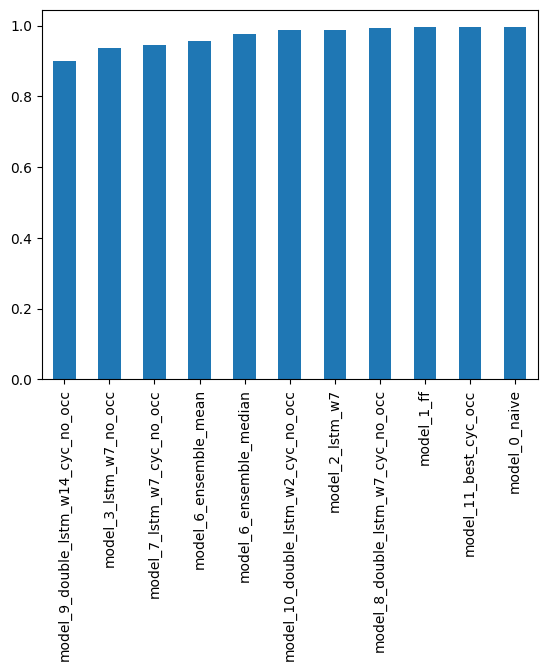

In [114]:
all_results_df['accuracy'].sort_values().plot(kind='bar')